# Titre du Notebook
# Analyse des Performances des Équipes de Rugby du Top 14

## Table des Matières
# 1. [Introduction et Objectifs](#introduction)
# 2. [Importation et Configuration](#import)
# 3. [Fonctions Utilitaires](#utils)
# 4. [Chargement et Préparation des Données](#data_prep)
# 5. [Analyse Exploratoire des Données](#eda)
# 6. [Modélisation avec Random Forest](#model)
# 7. [Visualisation des Résultats](#viz)
# 8. [Conclusion et Perspectives](#conclusion)



# <a id='introduction'></a>
## 1. Introduction et Objectifs

# Ce notebook a pour but d'analyser les performances des équipes de rugby du Top 14 
# en utilisant des techniques d'apprentissage automatique, notamment Random Forest.
# Nous allons identifier les indicateurs clés de performance (KPI) qui prédisent le mieux
# l'issue des matchs.

# To do list
- [ ] Refactorisation du code
- [ ] ~Déterminer les estimator du modèle RF~ et comparer avec les estimators du model gradient boosting qui optimise par lui meme le nombre d'estimators (n_estimators_) en utilisant une méthode d'early stopping (paramètre early_stopping = True, n_iter_no_change=10) 
- [ ] Lire la doc de classification_report
- [ ] Faire une boucle pour évaluer plusieurs modèles avec différentes features
- [ ] Utiliser plusieurs techniques pour sélectionner les Pi :
  -  Recursive feature elimination with cross-validation pour sélectionner les features
  -  Méthode univariée
  Expliquer les différence et pourquoi choisir RFE
- [ ] Plot Partial Dependence, pour indiquer à partir de quel quantité l'importance d'un caractéristique n'a plus d'effet sur le modèle
- [ ] Optimiser computation times avec 
    ``` 
    import joblib

    N_CORES = joblib.cpu_count(only_physical_cores=True)
    print(f"Number of physical cores: {N_CORES}")
    ```


# <a id='import'></a>
## 2. Importation et Configuration

In [1]:
# Importation des bibliothèques nécessaires
import sys
sys.path.append('..')

from src.data_processing import *
from src.database_utils import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, r2_score
from sklearn.inspection import partial_dependence, permutation_importance
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.feature_selection import RFE, RFECV
from IPython.display import Markdown
from IPython.display import display
import ipywidgets as widgets

import joblib
import json

N_CORES = joblib.cpu_count(only_physical_cores=True)
print(f"Number of physical cores: {N_CORES}")

Number of physical cores: 16


c:\Users\hans9\.conda\envs\data_analysis-env\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\hans9\.conda\envs\data_analysis-env\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


---

## Loading Key Performance Indicators (KPIs)

In this section, we load the Key Performance Indicators (KPIs) and descriptive data from a JSON configuration file.

### Configuration File Structure

The `config/kpi.json` file organizes KPIs into two main categories:
1. **General KPIs**: These indicators provide an overview of performance.
2. **Detailed KPIs**: These indicators offer a more in-depth analysis of specific game aspects.*
3. **Descriptive Data**: This category includes match and team identification information.

Each category is further divided into game dimensions:
- Play
- Defensive
- Set_piece
- Discipline
- Play_control

This structure allows for great flexibility in choosing KPIs for analysis.

> ✅ <span style="color:blue">**Note**</span> ✅ <br>
> Users can modify the `config/kpi.json` file and the subsequent code to select specific KPIs of interest. 


### KPI Selection for Our Analysis

For this study, we focus on general KPIs. This choice is motivated by the desire to maintain consistency with previous studies in the field, notably:

- [Bennett et al. (2018)](../bibliography/Bennett%20&%20al.%20(2018).pdf)
- [Scott et al. (2023), part. A](../bibliography/Scott%20&%20al.%20(2023,%20A).pdf)
- [Scott et al. (2023), part. B](../bibliography/Scott%20&%20al.%20(2023,%20B).pdf)

These studies used similar KPIs, allowing for a more direct comparison of our results with existing literature.

Here's a comparative table of KPIs used in these studies and those we've selected:

| Bennett et al. (2018)                         | Scott et al. (2023) A      | Scott et al. (2023) B      | Our analysis (General KPIs)            |
| --------------------------------------------- | -------------------------- | -------------------------- | -------------------------------------- |
| Carries made                                  | Carries                    | Carries                    | Runs                                   |
| Clean breaks                                  | Clean breaks               | Clean breaks               | Clean breaks                           |
| Offloads                                      | Offloads                   | Offloads                   | Offload                                |
| Total number of defenders beaten              | Defenders beaten           | Defenders beaten           | Defenders beaten                       |
| Total number of metres ball was carried       | Metres made                | Meters made                | Carries metres                         |
| Tackles made                                  | Tackles                    | Tackles                    | -                                      |
| Tackles missed                                | Missed tackles             | Missed tackles             | Missed tackles                         |
| Ratio tackles missed to tackles made          | -                          | -                          | Tackle success                         |
| Turnovers a team won                          | Turnovers won              | Turnovers won              | Turnover won                           |
| Turnovers a team conceded                     | Turnovers conceded         | Turnovers conceded         | Turnovers conceded                     |
| Lineout throws won on own ball                | Lineouts won               | Lineouts won               | Lineouts won                           |
| Lineout throws lost on own ball               | Lineouts lost              | Lineouts lost              | Lineouts lost                          |
| The number of kicks from hand                 | Kicks from hand            | Kicks from hand            | Kick from hand metres                  |
| Penalties conceded offence (with the ball)    | Penalties conceded         | Penalties conceded         | Penalties conceded                     |
| Penalties conceded defence (without the ball) | -                          | -                          | -                                      |
| The average distance for each ball carry      | -                          | -                          | -                                      |
| -                                             | Passes                     | Passes                     | Passes                                 |
| -                                             | Scrums won                 | Scrums won                 | Scrums won                             |
| -                                             | Scrums lost                | Scrums lost                | Scrums lost                            |
| -                                             | Rucks won                  | Rucks won                  | Rucks won                              |
| -                                             | Rucks lost                 | Rucks lost                 | Rucks lost                             |
| -                                             | Free kicks                 | Free kicks                 | Total free kicks conceded              |
| -                                             | Scrum penalties            | Scrum penalties            | -                                      |
| -                                             | Lineout penalties          | Lineout penalties          | -                                      |
| -                                             | Tackle/ruck/maul penalties | Tackle/ruck/maul penalties | -                                      |
| -                                             | General play penalties     | General play penalties     | -                                      |
| -                                             | Control penalties          | Control penalties          | -                                      |
| -                                             | Yellow cards               | Yellow cards               | Yellow cards                           |
| -                                             | Red cards                  | Red cards                  | Red cards                              |
| -                                             | Home/away status           | -                          | Home/away status                       |
| -                                             | -                          | -                          | Mauls won                              |
| -                                             | -                          | -                          | Mauls lost                             |
| -                                             | -                          | -                          | Mauling metres                         |
| -                                             | -                          | -                          | Collection failed                      |
| -                                             | -                          | -                          | Collection success                     |
| **TOTAL**                                     | **TOTAL**                  | **TOTAL**                  | **TOTAL**                              |
| 16                                            | 27                         | 26                         | 27                                     |


This table provides a comprehensive overview of the KPIs used in different studies and in our analysis. It shows that our selection covers most of the key indicators used in previous research while also including some additional metrics (like mauls and ball collection) that might provide extra insights into rugby performance.

This selection allows us to cover the essential aspects of performance while remaining aligned with current scientific literature.

> ✅ <span style="color:blue">**Note**</span> ✅ <br>
> If you have any doubts about the meaning of one of the selected KPi you can look it up in the dictionary at the [following address](https://github.com/hans-brgs/rugby-data-scraper/blob/main/dictionary/README.md). 

### Data Extraction Process

> 📢 <span style="color:red">**Important**</span> 📢<br>
> The KPIs and descriptive data names defined in this configuration file serve as feature selectors for the next step of our analysis. These names will be used to query and extract the relevant data from the view `view_team_match_stats` of our database.
> 
> For a detailed view of the database structure and available fields, please refer to the following link:
> [Rugby Data Scraper Database README](https://github.com/hans-brgs/rugby-data-scraper/blob/main/database/README.md)

In [2]:

# Loading KPIs from the configuration file
with open("../config/kpi.json", "r") as f:
	kpis = json.load(f)
	
# Extracting general KPIs
general_kpi = kpis["general"]
all_general_kpi = [el for key in general_kpi.keys() for values in general_kpi[key].values() for el in values]

# Add additional descriptive feature that will aid in processing and analyzing the data
descriptive_features = kpis["descriptive"]

# Selecting KPIs for the analysis (only general KPIs)
kpi_features = all_general_kpi

# We included the 'isHome' feature in our set of performance indicators.
kpi_features = kpi_features + ["isHome"]
# And we remove it from the descriptive features to avoid redundancy.
descriptive_features.remove("isHome")

selected_features = (descriptive_features + kpi_features)

### --- If you want to select all KPIs for analysis, uncomment the following lines ---
# Extracting detailed KPIs (not used in this analysis)		   
# detailled_kpi = kpis["detailled"]
# all_detailled_kpi = [el for key in detailled_kpi.keys() for values in detailled_kpi[key].values() for el in values]

# kpi_features = (all_general_kpi + all_detailled_kpi) 
# selected_features = (descriptive_data + kpi_features)

# -----------------------------------------------------------------------------------------------------------------------------
### MARKDOWN
text_markdown = f"""
### Data selected for analysis :

These feature names will be used to query the database in the next step.

For full database schema, refer to: https://github.com/hans-brgs/rugby-data-scraper/blob/main/database/README.md

{pd.DataFrame(selected_features).rename(columns={0 : "feature names"}).to_markdown()}
"""
display(Markdown(text_markdown))


### Data selected for analysis :

These feature names will be used to query the database in the next step.

For full database schema, refer to: https://github.com/hans-brgs/rugby-data-scraper/blob/main/database/README.md

|    | feature names          |
|---:|:-----------------------|
|  0 | matchEspnId            |
|  1 | matchName              |
|  2 | season                 |
|  3 | matchDate              |
|  4 | teamName               |
|  5 | opponentTeamName       |
|  6 | teamScore              |
|  7 | opponentTeamScore      |
|  8 | passes                 |
|  9 | offload                |
| 10 | cleanBreaks            |
| 11 | defendersBeaten        |
| 12 | runs                   |
| 13 | carriesMetres          |
| 14 | kickFromHandMetres     |
| 15 | totalFreeKicksConceded |
| 16 | rucksLost              |
| 17 | rucksWon               |
| 18 | maulsWon               |
| 19 | maulsLost              |
| 20 | maulingMetres          |
| 21 | turnoverWon            |
| 22 | turnoversConceded      |
| 23 | collectionFailed       |
| 24 | collectionSuccess      |
| 25 | tackleSuccess          |
| 26 | missedTackles          |
| 27 | scrumsWon              |
| 28 | scrumsLost             |
| 29 | lineoutsWon            |
| 30 | lineoutsLost           |
| 31 | redCards               |
| 32 | yellowCards            |
| 33 | penaltiesConceded      |
| 34 | isHome                 |


---

## Data Extraction and Preprocessing

After defining our Key Performance Indicators (KPIs) and descriptive features, we proceed to extract the relevant data from our database and preprocess it for analysis.

### Database Connection and Data Extraction

We use a configuration file (`db_config.json`) to manage our database connection parameters.

> 📢 <span style="color:red">**Important**</span> 📢<br>
> Before running this analysis, ensure you have installed and set up the database as described in the project's README file. Once set up, modify the `db_config.json` file to match your specific installation and database parameters. This step is crucial for successfully connecting to and querying the database.

The `db_config.json` file typically includes the following parameters:
- `host`: The database server address
- `user`: Your database username
- `password`: Your database password
- `database`: The name of the rugby statistics database

### Data Selection Criteria

For this analysis, we focus on the Top 14 data between 2017 and 2023 seasons, taking into account the following considerations:

1. **League Selection**: We exclusively analyze data from the "Top 14" league.
2. **Season Exclusion**: Data from the 2020 and 2021 seasons are excluded from our analysis due to the following reasons:
   - The 2020 season was interrupted due to the COVID-19 pandemic, potentially introducing inconsistencies in the data.
   - The 2021 season was played without spectators, which may have diminished the influence of the home/away status on performance, as suggested by [Scott et al. (2023), part. A](../bibliography/Scott%20&%20al.%20(2023,%20A).pdf).
3. **Playoff Exclusion**: The final eight matches of each season, corresponding to the playoff stage, are excluded from our dataset. These matches are played at neutral venues, thereby nullifying the home/away advantage typically observed during the regular season.

> 📢 <span style="color:red">**Important**</span> 📢<br>
> The exclusion of recent seasons (2020 and 2021) may have implications for our analysis:
> 
> 1. **Rule Changes**: Recent modifications to rugby regulations, such as the 50/22 law introduced in 2021, could significantly alter game dynamics. These changes may impact which KPIs are most significant in determining match outcomes. ([Strydom & al (2024)](../bibliography/Strydom%20&%20al.%20(2024).pdf))
> 
> 2. **Evolving Game Strategies**: The sport's tactical evolution in recent years might not be fully captured in our dataset, potentially affecting both our predictive models and the identification of the most significant KPIs.
> 
> 3. **Sample Size vs. Recency Trade-off**: To address these limitations, an alternative approach would have been to focus solely on the 2022 and 2023 seasons. This would have captured the most recent data, reflecting current rules and tactics. However, our current method prioritizes a larger dataset spanning multiple seasons, albeit at the cost of excluding the most recent periods. This choice presents a trade-off between between statistical robustness from a larger sample and the temporal relevance of more recent data.
>
> These limitations will be thoroughly addressed in our discussion of results, acknowledging the potential impact on the applicability of our findings to the most current rugby seasons.

In [3]:
# Load database configuration
with open("../config/db_config.json", "r") as f :
	db_config = json.load(f)
      
# Define SQL query parameters
conditions = ("season NOT IN (2020, 2021)", "leagueName = \"Top 14\"")
table_name = "view_team_match_stats"

# Extract data from database
with create_connection(db_config) as conn :
    data = execute_request(conn, table_name, selected_features, conditions)

# convert to pd dataframe
data_df = pd.DataFrame(data)

# Because the numerical data in the database is of decimal type, we convert it into float.
data_df = data_df.map(convert_decimal_to_float)

# Exluding playoff matches
regular_seasons_df = exclude_playoff(data_df)

SQL request send to MariaDB database :

        SELECT `matchEspnId`, `matchName`, `season`, `matchDate`, `teamName`, `opponentTeamName`, `teamScore`, `opponentTeamScore`, `passes`, `offload`, `cleanBreaks`, `defendersBeaten`, `runs`, `carriesMetres`, `kickFromHandMetres`, `totalFreeKicksConceded`, `rucksLost`, `rucksWon`, `maulsWon`, `maulsLost`, `maulingMetres`, `turnoverWon`, `turnoversConceded`, `collectionFailed`, `collectionSuccess`, `tackleSuccess`, `missedTackles`, `scrumsWon`, `scrumsLost`, `lineoutsWon`, `lineoutsLost`, `redCards`, `yellowCards`, `penaltiesConceded`, `isHome` 
        FROM view_team_match_stats
        WHERE (season NOT IN (2020, 2021)) AND (leagueName = "Top 14")
    


---

## Analysis of Match Counts and Data Completeness

To ensure transparency and assess the robustness of our dataset, we conducted an analysis of the number of matches included per season and identified any missing data. This step is crucial for understanding the scope and limitations of our analysis.

### Methodology

1. **Total Match Count**: We counted the total number of data rows per season. Since each match is represented by two rows (one for each team), we divided this count by 2 to get the actual number of unique matches.

2. **Complete Data Count**: We then counted the number of rows with complete data (no missing values) for each season.

3. **Missing Data Identification**: By comparing the total match count with the complete data count, we identified the number of matches with missing data for each season.

In [4]:
from IPython.display import Markdown, display

# Count total rows per season
total_matches  = regular_seasons_df.groupby('season').size().reset_index(name='count')

# Count rows without missing data
complete_matches  = regular_seasons_df.dropna().groupby('season').size().reset_index(name='count')
missing_matches = regular_seasons_df[regular_seasons_df.isna().any(axis=1)]

# Remove missing data
regular_seasons_df = regular_seasons_df.dropna()

# Merge and calculate statistics
match_stats = total_matches
match_stats["unique_matches"] = match_stats["count"] // 2
match_stats["matches_without_missing"] = complete_matches["count"] // 2
match_stats["missing_matches"] = match_stats["unique_matches"] - match_stats['matches_without_missing']

#-------------------------------------------------------------------------------------------------------------------------------------------------------

### MARKDOWN 

# convert df to markdown
match_stats_md = match_stats.to_markdown(index=False)
missing_matches_md = missing_matches[["season", "matchName", "matchDate"]].to_markdown(index=False)

# Text markdown
markdown_text = f"""
### Results
- The 'unique_matches' column represents the total number of matches analyzed per season.
- The 'missing_matches' column indicates how many matches have incomplete data in each season.<br>

{match_stats_md}

The results show that each season consistently includes 182 unique matches, which is the expected number for the Top 14 competition, 
according to [Top 14 Wikipedia](https://en.wikipedia.org/wiki/Top_14). Each team plays 26 matches during the regular season. 
With 14 teams in the league, this gives 182 unique matches per season (14 teams * 26 matches / 2), confirming that our database is complete in terms of match quantity.

The majority of the seasons included in the analyses (2017, 2018, 2022, 2023 and 2024), present complete data for all 182 matches. However, for the 2019 season, 7 matches have missing data :

{missing_matches_md}

When we analyze the missing data, we observe that these data correspond to matches on the first day of the 2017 season.
"""

display(Markdown(markdown_text))


### Results
- The 'unique_matches' column represents the total number of matches analyzed per season.
- The 'missing_matches' column indicates how many matches have incomplete data in each season.<br>

|   season |   count |   unique_matches |   matches_without_missing |   missing_matches |
|---------:|--------:|-----------------:|--------------------------:|------------------:|
|     2017 |     364 |              182 |                       182 |                 0 |
|     2018 |     364 |              182 |                       182 |                 0 |
|     2019 |     364 |              182 |                       175 |                 7 |
|     2022 |     364 |              182 |                       182 |                 0 |
|     2023 |     364 |              182 |                       182 |                 0 |
|     2024 |     364 |              182 |                       182 |                 0 |

The results show that each season consistently includes 182 unique matches, which is the expected number for the Top 14 competition, 
according to [Top 14 Wikipedia](https://en.wikipedia.org/wiki/Top_14). Each team plays 26 matches during the regular season. 
With 14 teams in the league, this gives 182 unique matches per season (14 teams * 26 matches / 2), confirming that our database is complete in terms of match quantity.

The majority of the seasons included in the analyses (2017, 2018, 2022, 2023 and 2024), present complete data for all 182 matches. However, for the 2019 season, 7 matches have missing data :

|   season | matchName                                | matchDate           |
|---------:|:-----------------------------------------|:--------------------|
|     2019 | Montpellier Herault vs Castres Olympique | 2018-08-26 15:05:00 |
|     2019 | Montpellier Herault vs Castres Olympique | 2018-08-26 15:05:00 |
|     2019 | Toulon vs Racing 92                      | 2018-08-25 18:45:00 |
|     2019 | Toulon vs Racing 92                      | 2018-08-25 18:45:00 |
|     2019 | Bordeaux Begles vs Pau                   | 2018-08-25 15:15:00 |
|     2019 | Bordeaux Begles vs Pau                   | 2018-08-25 15:15:00 |
|     2019 | Clermont Auvergne vs Agen                | 2018-08-25 15:15:00 |
|     2019 | Clermont Auvergne vs Agen                | 2018-08-25 15:15:00 |
|     2019 | Lyon vs Stade Toulousain                 | 2018-08-25 15:15:00 |
|     2019 | Lyon vs Stade Toulousain                 | 2018-08-25 15:15:00 |
|     2019 | La Rochelle vs Grenoble                  | 2018-08-25 15:15:00 |
|     2019 | La Rochelle vs Grenoble                  | 2018-08-25 15:15:00 |
|     2019 | Perpignan vs Stade Francais Paris        | 2018-08-25 12:45:00 |
|     2019 | Perpignan vs Stade Francais Paris        | 2018-08-25 12:45:00 |

When we analyze the missing data, we observe that these data correspond to matches on the first day of the 2017 season.


---

## Methodological Approach: Relative vs. Isolated Performance Indicators

In our analysis, we opted to construct our models using relative performance indicators (PIs) rather than isolated PI data. This methodological choice is grounded in recent advancements in rugby performance analysis literature.

### Relative Data Calculation

Relative data are calculated by computing the difference in each PI between opposing teams for each match. 
> 💡 <span style="color:green"> **Exemple :** </span>💡 <br> 
> - Team A gained 200 meters
> - Team B gained 400 meters
> 
> The relative data would be -200 meters for Team A and +200 meters for Team B, as opposed to the isolated values of 200 and 400 meters, respectively.

### Justification for Relative Data Usage

Our decision to use relative data is supported by a growing body of evidence in rugby performance analysis. The decision to use relative data is supported by evidence from recent rugby performance analysis studies. Bennett et al. (2018) and Scott et al. (2023a, 2023b) have shown improved match outcome prediction when using relative data compared to standard PI values.

These studies suggest that relative data capture the interaction between opposing teams more effectively. Bennett et al. (2018) reported that models using relative data achieved higher predictive accuracy (80%) compared to those using isolated data (64% accuracy). Similarly, Scott et al. (2023a) found that relative data models correctly classified 85% of match outcomes, outperforming isolated data models (66% accuracy).

The superiority of relative data in predictive modeling is attributed to its ability to contextualize performance by capturing some of the dynamics of the opposition. This approach corresponds to the complex, interactive nature of rugby, where team performance is intrinsically linked to the actions of the opponent.

In [5]:
# Calculate relative statistics
regular_seasons_relative_df = calculate_relative_stats(regular_seasons_df, kpi_features, descriptive_features)

#-------------------------------------------------------------------------------------------------------------------------------------------------------

### Check data Integrity
# Select columns to display
columns_to_show = ['season', 'matchDate', 'teamName', 'opponentTeamName', 'passes', 'offload', 'cleanBreaks']

# Create markdown text
markdown_text = f"""
## Comparison of Isolated and Relative Data

### Isolated Data Sample
{regular_seasons_df.sort_values('matchEspnId').loc[:, columns_to_show].head(2).to_markdown(index=False)}

### Relative Data Sample
{regular_seasons_relative_df.sort_values('matchEspnId').loc[:, columns_to_show].head(2).to_markdown(index=False)}

**Note:** The relative data shows the difference between each team's performance and their opponent's for the selected metrics. 
Positive values indicate a superior performance to that of the opponent for a given measure, and vice versa.
"""
# Display the markdown
display(Markdown(markdown_text))


## Comparison of Isolated and Relative Data

### Isolated Data Sample
|   season | matchDate           | teamName   | opponentTeamName   |   passes |   offload |   cleanBreaks |
|---------:|:--------------------|:-----------|:-------------------|---------:|----------:|--------------:|
|     2017 | 2016-08-21 16:15:00 | Toulon     | Bayonne            |      126 |        18 |            14 |
|     2017 | 2016-08-21 16:15:00 | Bayonne    | Toulon             |      105 |         8 |            11 |

### Relative Data Sample
|   season | matchDate           | teamName   | opponentTeamName   |   passes |   offload |   cleanBreaks |
|---------:|:--------------------|:-----------|:-------------------|---------:|----------:|--------------:|
|     2017 | 2016-08-21 16:15:00 | Toulon     | Bayonne            |       21 |        10 |             3 |
|     2017 | 2016-08-21 16:15:00 | Bayonne    | Toulon             |      -21 |       -10 |            -3 |

**Note:** The relative data shows the difference between each team's performance and their opponent's for the selected metrics. 
Positive values indicate a superior performance to that of the opponent for a given measure, and vice versa.


---

## Match Outcome Classification

### Binary Outcome Derivation

Our database contains match scores but does not explicitly categorize outcomes as win or loss. Therefore, we implemented a classification process to derive binary outcomes from the score data.

### Handling of Drawn Matches

We excluded matches that ended in a draw from our dataset. This decision was made to ensure a clear binary classification of match outcomes and to maintain consistency with previous studies in the field ([Bennett et al. (2018)](../bibliography/Bennett%20&%20al.%20(2018).pdf), [Scott et al. (2023), part. A](../bibliography/Scott%20&%20al.%20(2023,%20A).pdf), [Scott et al. (2023), part. B](../bibliography/Scott%20&%20al.%20(2023,%20B).pdf)).

### Classification Method for Drawn Matches

The match outcome classification process involved the following steps:

1. Matches were classified as wins or losses based on the final score.
2. Drawn matches were identified and removed from the dataset.

This classification is based on the premise that achieving a draw away from home may be considered a relative success, given the challenges associated with away fixtures. In our dataset, X% of away matches result in a loss, underscoring the difficulty of performing well in away games.

### Future Considerations

While this approach is currently standard in the field, future research could explore the impact of including drawn matches or developing more nuanced classification methods that capture the complexity of match outcomes in rugby.


In [6]:

# Step 1 : count draw match 
number_of_draw_matches = len(regular_seasons_relative_df[regular_seasons_relative_df['scoreDiff'] == 0])
total_matches = len(regular_seasons_relative_df)

# Step 2 : drop draw match
regular_seasons_relative_without_draw_df = regular_seasons_relative_df.drop(regular_seasons_relative_df[regular_seasons_relative_df['scoreDiff'] == 0].index)

# Step 3 : win / lose classification
conditions = [
    (regular_seasons_relative_without_draw_df['scoreDiff'] > 0),  # Condition 1: score_diff > 0
    (regular_seasons_relative_without_draw_df['scoreDiff'] < 0),  # Condition 2: score_diff < 0
]
choices = [True, False]

# Create the 'is_winner' column with numpy.select
regular_seasons_relative_without_draw_df['isWinner'] = np.select(conditions, choices, default=np.nan)

#-------------------------------------------------------------------------------------------------------------------------------------------------------

### Check data Integrity
# Select columns to display
columns_to_show = ['season', 'matchDate', 'teamName', 'opponentTeamName', 'teamScore', 'opponentTeamScore', 'isWinner']

# Create markdown text
markdown_text = f"""
## Analysis of Drawn Matches and Data Processing

### Drawn Match Statistics

- Total matches in dataset: {total_matches}
- Number of drawn matches: {number_of_draw_matches}
- Percentage of drawn matches: {(number_of_draw_matches/total_matches*100):.2f}%

### Impact of Excluding Drawn Matches

The relatively low percentage of drawn matches ({(number_of_draw_matches/total_matches*100):.2f}%) suggests that their exclusion is unlikely to significantly impact our analysis.

### Data Sample After Processing

The following table presents a sample of the processed dataset, illustrating the binary classification of match outcomes:

{regular_seasons_relative_without_draw_df.sort_values("matchEspnId").loc[:, columns_to_show].head(2).to_markdown(index=False)}

"""
# Display the markdown
display(Markdown(markdown_text))


## Analysis of Drawn Matches and Data Processing

### Drawn Match Statistics

- Total matches in dataset: 2170
- Number of drawn matches: 62
- Percentage of drawn matches: 2.86%

### Impact of Excluding Drawn Matches

The relatively low percentage of drawn matches (2.86%) suggests that their exclusion is unlikely to significantly impact our analysis.

### Data Sample After Processing

The following table presents a sample of the processed dataset, illustrating the binary classification of match outcomes:

|   season | matchDate           | teamName   | opponentTeamName   |   teamScore |   opponentTeamScore |   isWinner |
|---------:|:--------------------|:-----------|:-------------------|------------:|--------------------:|-----------:|
|     2017 | 2016-08-21 16:15:00 | Toulon     | Bayonne            |          23 |                  28 |          0 |
|     2017 | 2016-08-21 16:15:00 | Bayonne    | Toulon             |          28 |                  23 |          1 |



## Model Configuration and Training

After completing the data loading, extraction, and transformation steps, we now proceed to configure and train our Random Forest model to determine the key predictors of match outcomes in rugby.

### Optimizing the Number of Estimators

The first step in our model configuration process is to determine the optimal number of estimators (decision trees) for our Random Forest classifier.

#### Methodology

1. **Estimator Range**:
   - We tested a range of estimators from 1 to 500, incrementing by 25.
   - This wide range allows us to observe the model's performance across varying levels of complexity.

2. **Cross-Validation Setup**:
   - We employed 5-fold stratified cross-validation to ensure robust performance estimation across different subsets of our data.
   - This approach helps mitigate overfitting and provides a more reliable estimate of model performance.

3. **Performance Metric**:
   - We used accuracy as our primary performance metric, which is appropriate for our balanced binary (our two classes : lose/win are roughly equally represented in the dataset) classification task.

4. **Stability Analysis**:
   - We implemented a custom function (`mean_threshold_detection`) to identify the point at which the model's performance stabilizes.
   - This helps in selecting the optimal number of estimators without unnecessary computational overhead.

In [7]:
# Feature preparation
X = regular_seasons_relative_without_draw_df[kpi_features]
y = regular_seasons_relative_without_draw_df["isWinner"]

# Range of estimators to test
n_estimators = list(range(1, 90, 10)) + list(range(100, 500, 25))

# Cross-validation and scoring
results = []
for n in n_estimators :
    rf = RandomForestClassifier(n_estimators=n, random_state=42)
    scores = cross_val_score(estimator=rf, X=X, y=y, scoring="accuracy", cv=StratifiedKFold(5), n_jobs= int(N_CORES/2))
    results.append({
        'n_estimators': n,
        'mean_score': np.mean(scores),
        'std_score': np.std(scores)
    })

# Convertir les résultats en DataFrame
scores_df = pd.DataFrame(results)

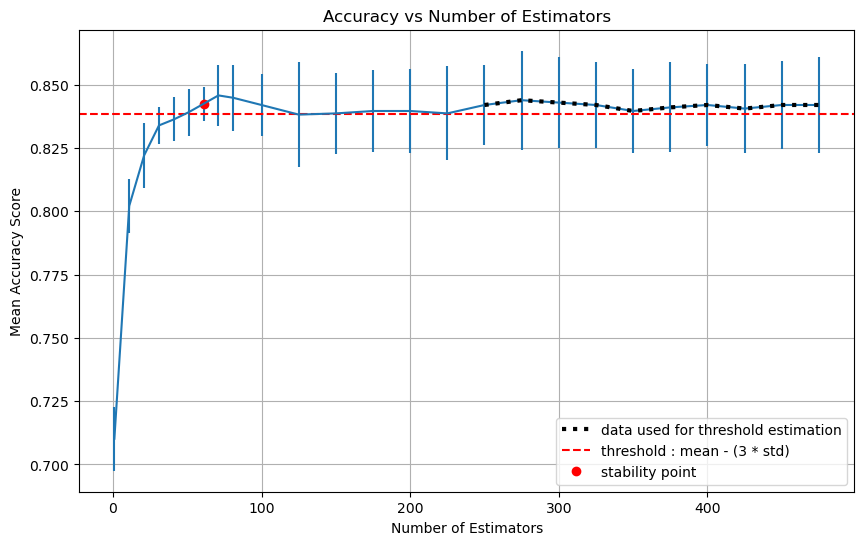


### Results and Interpretation

The graph illustrates the relationship between the number of estimators and the model's accuracy. We observe that:

1. The model's performance generally improves as the number of estimators increases.
2. The performance stabilizes after a certain point, indicated by the red dot on the graph.
3. The optimal number of estimators is **61**, achieving an accuracy of **0.8425**.

This analysis allows us to select an efficient model configuration that balances computational cost with predictive performance. 
In subsequent analyses, we will use this optimal number of estimators to train our final model and determine the key predictors of rugby match outcomes.



In [8]:

# Stability point detection
flat_curve_start_idx = -10
flat_curve_end_idx = None
stable_point_idx, thr = mean_threshold_detection(scores_df['mean_score'], flat_curve_start_idx, flat_curve_end_idx, window_size=3)

stable_point_val = scores_df['mean_score'][stable_point_idx]
optimal_estimators = scores_df['n_estimators'][stable_point_idx]

# Visualization
plt.figure(figsize=(10,6))
plt.plot(scores_df['n_estimators'][flat_curve_start_idx : flat_curve_end_idx], 
		 scores_df['mean_score'][flat_curve_start_idx: flat_curve_end_idx], 
		 ":k", label="data used for threshold estimation", linewidth=3, zorder=5)
plt.errorbar(scores_df['n_estimators'], scores_df['mean_score'], yerr=scores_df['std_score'])
plt.axhline(y = thr, linestyle="--", color="r", label="threshold : mean - (3 * std)")
plt.plot(optimal_estimators, stable_point_val, "or", label="stability point")
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Accuracy Score')
plt.title('Accuracy vs Number of Estimators')
plt.grid(True)
plt.legend()
plt.show()

#-----------------------------------------------------------------------------------------------------------------------------------------
### MARKDOWN

# Create markdown text
markdown_text = f"""
### Results and Interpretation

The graph illustrates the relationship between the number of estimators and the model's accuracy. We observe that:

1. The model's performance generally improves as the number of estimators increases.
2. The performance stabilizes after a certain point, indicated by the red dot on the graph.
3. The optimal number of estimators is **{optimal_estimators}**, achieving an accuracy of **{stable_point_val:.4f}**.

This analysis allows us to select an efficient model configuration that balances computational cost with predictive performance. 
In subsequent analyses, we will use this optimal number of estimators to train our final model and determine the key predictors of rugby match outcomes.

"""
# Display the markdown
display(Markdown(markdown_text))

---

## Identification of Key Performance Predictors

### Objective
The primary aim of this phase of the analysis is to identify the most significant predictors of performance in rugby matches. To ensure robustness and reliability in our findings, we employed three distinct feature selection methods: **Recursive Feature Elimination with Cross-Validation** (RFECV), **Random Forest Classifier feature importance**, and **Permutation Importance**.

### Methodology

#### 1. Recursive Feature Elimination with Cross-Validation (RFECV)
RFECV was utilized to determine the optimal number of features while maintaining model performance. This method iteratively removes the least important features and evaluates the model's performance using cross-validation. It's important to note that RFECV does not provide a ranking of importance among the selected features. The method focuses on identifying the optimal subset of features for model performance, rather than ordering them by importance within that subset.

While the order of elimination during the recursive process could potentially provide some insight into feature importance, this should not be interpreted as a definitive ranking, especially for the final selected features. The selected features should be considered as a collective set that optimizes the model's performance, without implying a specific order of importance among them.


In [9]:
# Initialize the Random Forest Classifier with optimal number of estimators
rf = RandomForestClassifier(n_estimators=optimal_estimators, random_state=42)

# Set the number of cross-validation folds
fold = 5

# Initialize RFECV (Recursive Feature Elimination with Cross-Validation)
rfecv = RFECV(
    estimator=rf,
    step=1,
    cv=StratifiedKFold(fold),
    scoring="accuracy",
    min_features_to_select=1,
    n_jobs=int(N_CORES//2),
)
# Fit RFECV to the data
rfecv.fit(X, y)

RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(n_estimators=np.int64(61),
                                       random_state=42),
      n_jobs=8, scoring='accuracy')

In [10]:
# Extract number of features and corresponding mean and std accuracy scores
n_features = rfecv.cv_results_["n_features"]  
mean_score = rfecv.cv_results_["mean_test_score"]  
std_score = rfecv.cv_results_["std_test_score"]

# Set parameters for identifying the stabilization point
flat_curve_start_idx = -15
flat_curve_end_idx = None

# Identify the stabilization point using a customized threshold stabilization detection function.
stable_point_id, thr = mean_threshold_detection(mean_score, flat_curve_start_idx, flat_curve_end_idx, 3)

# Find the maximum accuracy and its corresponding index
max_accuracy_id = np.argmax(mean_score)
max_accuracy_val = np.max(mean_score)

# Calculate 95% Confidence Intervals for stable point and max accuracy
CI_stable_point_accuracy = stats.t.interval(confidence=0.95, df=fold-1, loc=mean_score[stable_point_id], scale=std_score[stable_point_id]/np.sqrt(fold))
CI_max_accuracy = stats.t.interval(confidence=0.95, df=fold-1, loc=mean_score[max_accuracy_id], scale=std_score[max_accuracy_id]/np.sqrt(fold))

# Perform Recursive Feature Elimination with the optimal number of features
rfe = RFE(estimator=rf, n_features_to_select=n_features[stable_point_id])
rfe.fit(X, y)


RFE(estimator=RandomForestClassifier(n_estimators=np.int64(61),
                                     random_state=42),
    n_features_to_select=np.int64(9))

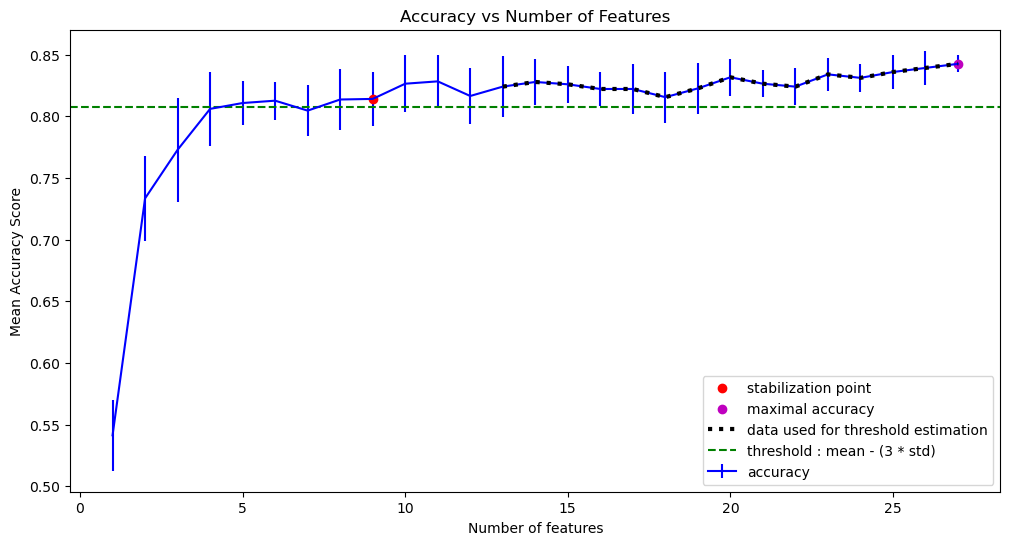


### RFECV Analysis Results

The graph illustrates the relationship between the number of features and the model's accuracy in predicting rugby match outcomes.

#### Key observations:

1. **Rapid initial increase**: Accuracy improves quickly with the first few features added, rising from about 0.54 to 0.81 with only 5 features.

2. **Performance Plateau**: After about 9 features, 
accuracy score stabilizes around 0.814 (81%), with minor fluctuation. 
Notably, while our algorithm identifies the plateau at 9 features, 
the average accuracy between 5 and 9 features does not significantly increase.

3. **Diminishing Returns**: Adding features beyond this point only marginally improves accuracy, suggesting a good trade-off between model complexity and performance. 
However, the accuracy and 95% confidence interval for the stabilization point accuracy 
(acc = 0.814, CI95%[0.79, 0.84]) 
overlaps little with that of the maximum accuracy obtained using all features (acc=0.843,  CI95%[0.83, 0.85]).
Moreover, the standard deviation at the point of maximum accuracy is the lowest, indicating reduced variance and increased robustness of the model at this point.

In summary, although the performance plateau is technically identified at 9 features, the improvement between 5 and 9 features is not significant. 
Nevertheless, the minimal overlap of the confidence intervals and the reduced standard deviation at 
the point of maximum accuracy suggest that retaining all features might be tempting to optimize the model's accuracy.

#### Selected Features:

The features retained are the 9 features identified by our algorithm. 
This selection balances high accuracy and reduced complexity, making the model more interpretable and efficient for practical use.
|    | selected features   |
|---:|:--------------------|
|  0 | passes              |
|  1 | cleanBreaks         |
|  2 | carriesMetres       |
|  3 | kickFromHandMetres  |
|  4 | rucksWon            |
|  5 | maulingMetres       |
|  6 | turnoversConceded   |
|  7 | tackleSuccess       |
|  8 | isHome              |



In [11]:

plt.figure(figsize = (12, 6))
plt.errorbar(n_features, mean_score, yerr=std_score, color='b', linestyle='-', label="accuracy")
plt.plot(n_features[stable_point_id], mean_score[stable_point_id], 'ro', label="stabilization point")
plt.plot(n_features[max_accuracy_id], mean_score[max_accuracy_id], 'mo', label="maximal accuracy")
plt.plot(n_features[flat_curve_start_idx : flat_curve_end_idx], mean_score[flat_curve_start_idx : flat_curve_end_idx], ":k", label="data used for threshold estimation", linewidth=3, zorder=5)
plt.axhline(y=thr, color='g', linestyle='--' ,label="threshold : mean - (3 * std)")
plt.xlabel('Number of features')
plt.ylabel('Mean Accuracy Score')
plt.title('Accuracy vs Number of Features')
plt.legend()
plt.show()

#-----------------------------------------------------------------------------------------------------------------------------------------
### MARKDOWN

# Create markdown text
markdown_text = f"""
### RFECV Analysis Results

The graph illustrates the relationship between the number of features and the model's accuracy in predicting rugby match outcomes.

#### Key observations:

1. **Rapid initial increase**: Accuracy improves quickly with the first few features added, rising from about {mean_score[0]:.2f} to {mean_score[4]:.2f} with only 5 features.

2. **Performance Plateau**: After about {n_features[stable_point_id]} features, 
accuracy score stabilizes around {mean_score[stable_point_id]:.3f} ({mean_score[stable_point_id] * 100:.0f}%), with minor fluctuation. 
Notably, while our algorithm identifies the plateau at {n_features[stable_point_id]} features, 
the average accuracy between 5 and {n_features[stable_point_id]} features does not significantly increase.

3. **Diminishing Returns**: Adding features beyond this point only marginally improves accuracy, suggesting a good trade-off between model complexity and performance. 
However, the accuracy and 95% confidence interval for the stabilization point accuracy 
(acc = {mean_score[stable_point_id]:.3f}, CI95%[{CI_stable_point_accuracy[0]:.2f}, {CI_stable_point_accuracy[1]:.2f}]) 
overlaps little with that of the maximum accuracy obtained using all features (acc={mean_score[-1]:.3f},  CI95%[{CI_max_accuracy[0]:.2f}, {CI_max_accuracy[1]:.2f}]).
Moreover, the standard deviation at the point of maximum accuracy is the lowest, indicating reduced variance and increased robustness of the model at this point.

In summary, although the performance plateau is technically identified at 9 features, the improvement between 5 and 9 features is not significant. 
Nevertheless, the minimal overlap of the confidence intervals and the reduced standard deviation at 
the point of maximum accuracy suggest that retaining all features might be tempting to optimize the model's accuracy.

#### Selected Features:

The features retained are the 9 features identified by our algorithm. 
This selection balances high accuracy and reduced complexity, making the model more interpretable and efficient for practical use.
{pd.DataFrame(rfe.get_feature_names_out()).rename(columns={0: "selected features"}).to_markdown()}

"""
# Display the markdown
display(Markdown(markdown_text))



---

After using the RFECV (Recursive Feature Elimination with Cross-Validation) method to select the most relevant features for our rugby match outcome prediction model, we employed two additional approaches to validate and deepen our understanding of the importance of different variables. These complementary methods are:

#### 2.Built-in Random Forest Feature Importance
This method uses the native importance measure of the Random Forest model, based on the average impurity reduction brought by each feature in the decision trees.

#### 3. Permutation Feature Importance
This technique assesses the importance of a feature by measuring the decrease in model performance when the values of this feature are randomly permuted. This method is used by ([Bennett et al. (2018)](../bibliography/Bennett%20&%20al.%20(2018).pdf), [Scott et al. (2023), part. A](../bibliography/Scott%20&%20al.%20(2023,%20A).pdf), [Scott et al. (2023), part. B](../bibliography/Scott%20&%20al.%20(2023,%20B).pdf)) to select features.


Unlike RFECV, these two methods do not automatically select a subset of features while maintaining model performance. Instead, they rank features by their relative importance, providing a different perspective on feature relevance.

Using these complementary methods allows us to:
- Confirm or nuance the results obtained by RFECV
- Identify potential divergences between methods
- Obtain a more robust overview of the relative importance of different variables in our prediction model
- Gain insights into feature relevance that go beyond subset selection

In [12]:
#Fit random classifier model to the data, with all features (n = 30).
rf.fit(X, y)

# Random Forest Feature Importance
feature_importance = pd.DataFrame({'features': X.columns.tolist(), 'mean_importance': rf.feature_importances_})
feature_importance = feature_importance.sort_values('mean_importance', ascending=False)

# Permutation Feature Importance
result = permutation_importance(rf, X, y, n_repeats=30, random_state=42, n_jobs=int(N_CORES//2))
feature_permutation_importance = pd.DataFrame({'features': X.columns, 'mean_importance':result.importances_mean})
feature_permutation_importance = feature_permutation_importance.sort_values('mean_importance', ascending=False)

# Get intersection of the three list of features using the number of selected features of RFCEV as cutoff.
intersection_selected_features = list(set(feature_permutation_importance["features"][:n_features[stable_point_id]]) & 
								  set(feature_importance["features"][:n_features[stable_point_id]]) & 
								  set(rfe.get_feature_names_out()))


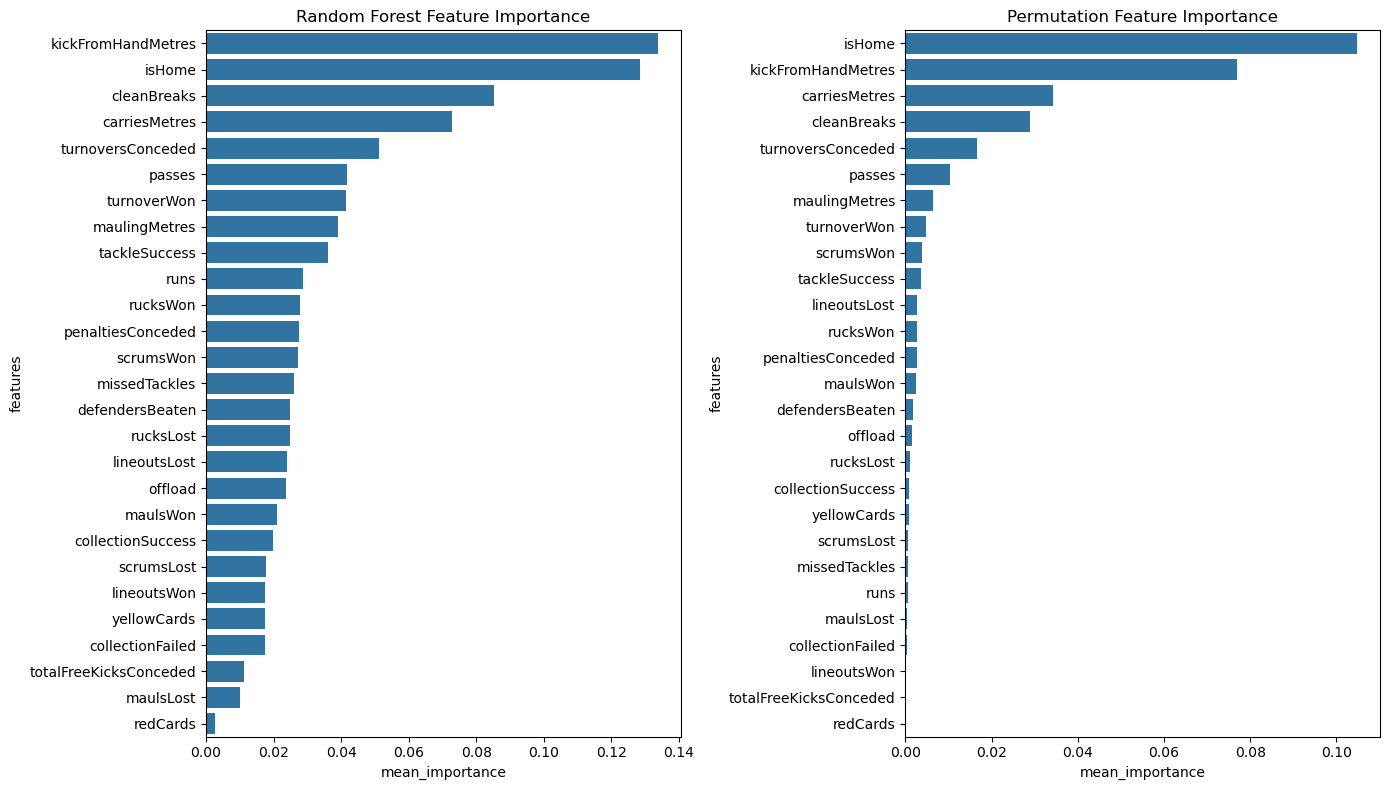


## Analysis of Feature Importance Results

The analysis of feature importance through three different methods (RFECV, built-in Random Forest importance, and permutation importance) 
has revealed interesting insights into the key factors influencing rugby match outcomes.

### Key Observations:

1. **Concordance across methods**: 7 features are common across all three methods: 

|    | common features accross methods   |
|---:|:----------------------------------|
|  0 | turnoversConceded                 |
|  1 | isHome                            |
|  2 | cleanBreaks                       |
|  3 | maulingMetres                     |
|  4 | kickFromHandMetres                |
|  5 | carriesMetres                     |
|  6 | passes                            |. 

This concordance strengthens confidence in the importance of these variables.

2. **Home advantage significance**: 'isHome' appears as the most important feature in both graphs, highlighting the significant advantage of playing at home in rugby.

3. **Kicking game importance**: The difference of 'kickFromHandMetres' between teams is ranked second in both methods, 
indicating the crucial importance of the kicking game in team strategy and success.

4. **Key offensive factors**: A higher number of 'cleanBreaks' and 'carriesMetres' than an opponnet are highly ranked, 
emphasizing the importance of the ability to gain ground and break through the opposing defense.

5. **Defensive factors**: 'turnoversConceded' and 'tackleSuccess' are among the important features, underlining the importance of defense and ball retention.

6. **Territorial gain emphasis**: Among the 7 common features, 
four ('carriesMetres', 'kickFromHandMetres', 'cleanBreaks', and 'maulingMetres') directly relate to gaining territory,
 reinforcing the fundamental nature of rugby as a territorial game where advancing the ball is crucial for success.

### Implications:

These results suggest that teams should focus on:
- Maximizing home field advantage
- Developing an effective strategic kicking game
- Improving the ability to gain ground and create breakthroughs
- Minimizing turnovers and increasing tackling efficiency


In [13]:

fig, ax = plt.subplots(1, 2, figsize=(14, 8))
sns.barplot(x='mean_importance', y='features', data=feature_importance, ax=ax[0])
ax[0].set_title('Random Forest Feature Importance')

sns.barplot(x='mean_importance', y='features', data=feature_permutation_importance, ax=ax[1])
ax[1].set_title('Permutation Feature Importance')

plt.tight_layout()
plt.show()

#-----------------------------------------------------------------------------------------------------------------------------------------
### MARKDOWN

# Create markdown text
markdown_text = f"""
## Analysis of Feature Importance Results

The analysis of feature importance through three different methods (RFECV, built-in Random Forest importance, and permutation importance) 
has revealed interesting insights into the key factors influencing rugby match outcomes.

### Key Observations:

1. **Concordance across methods**: {len(intersection_selected_features)} features are common across all three methods: 

{pd.DataFrame(intersection_selected_features).rename(columns={0 : 'common features accross methods'}).to_markdown()}. 

This concordance strengthens confidence in the importance of these variables.

2. **Home advantage significance**: 'isHome' appears as the most important feature in both graphs, highlighting the significant advantage of playing at home in rugby.

3. **Kicking game importance**: The difference of 'kickFromHandMetres' between teams is ranked second in both methods, 
indicating the crucial importance of the kicking game in team strategy and success.

4. **Key offensive factors**: A higher number of 'cleanBreaks' and 'carriesMetres' than an opponnet are highly ranked, 
emphasizing the importance of the ability to gain ground and break through the opposing defense.

5. **Defensive factors**: 'turnoversConceded' and 'tackleSuccess' are among the important features, underlining the importance of defense and ball retention.

6. **Territorial gain emphasis**: Among the {len(intersection_selected_features)} common features, 
four ('carriesMetres', 'kickFromHandMetres', 'cleanBreaks', and 'maulingMetres') directly relate to gaining territory,
 reinforcing the fundamental nature of rugby as a territorial game where advancing the ball is crucial for success.

### Implications:

These results suggest that teams should focus on:
- Maximizing home field advantage
- Developing an effective strategic kicking game
- Improving the ability to gain ground and create breakthroughs
- Minimizing turnovers and increasing tackling efficiency
"""
# Display the markdown
display(Markdown(markdown_text))



## Analysis part II

Having identified and validated the most relevant Key Performance Indicators (KPIs) for predicting rugby match outcomes, we will now proceed to the second part of our analysis. This phase aims to test the predictive capability of our model on the matches of the 2023 Top 14 season.

To accomplish this, the model will be trained using data from the 2017, 2018, 2019, and 2022 seasons. The 2020 and 2021 seasons are excluded due to COVID-19 pandemic-related disruptions. The KPI values for the 2023 season matches will be simulated using historical data. The actual 2023 match outcomes will then be used to verify the accuracy of the model's predictions based on these simulated data.

To simulate the KPIs for each 2023 match, the model will calculate the average performance over the 14 most recent matches preceding the date of the match to be predicted. These 14 matches will be selected based on the home/away status of the match to be predicted. For instance, for a home game, only the team's 14 most recent home matches will be considered. This approach aims to replicate real-world prediction conditions, where only historical data is available.

0.75426944971537


In [15]:
print(intersection_selected_features)

['turnoversConceded', 'isHome', 'cleanBreaks', 'maulingMetres', 'kickFromHandMetres', 'carriesMetres', 'passes']


In [55]:
# Prepare data set for training, and true values
training_data_set = regular_seasons_relative_without_draw_df[regular_seasons_relative_without_draw_df.season < 2023]
validation_data_set = regular_seasons_relative_without_draw_df[regular_seasons_relative_without_draw_df.season == 2023]

# Training the model with training data 
X_training = training_data_set[list(intersection_selected_features)]
y_training = training_data_set["isWinner"]
rf_prediction = RandomForestClassifier(n_estimators=optimal_estimators, random_state=42).fit(X_training, y_training)

# Create dataset with predictions based on 14 latest matches per team, using mean of selected features
simulated_data_set = validation_data_set.apply(lambda row: get_predicted_matches(row, regular_seasons_relative_without_draw_df, intersection_selected_features, descriptive_features, 14), axis=1)

# Prediction
X_predicted = simulated_data_set[intersection_selected_features]
y_pred = rf_prediction.predict(X_predicted)
report = classification_report(validation_data_set["isWinner"], y_pred, target_names=["Lose", "Win"], output_dict=True)
report_df = pd.DataFrame(report)[["Lose", "Win"]]

#-----------------------------------------------------------------------------------------------------------------------------------------
### MARKDOWN

# Create markdown text
markdown_text = f"""
## Analysis of Feature Importance Results

The random forest model was evaluated on a validation dataset comprising {report["Lose"]["support"]} unique matches from the 2023 Top 14 season.
The model's performance metrics are presented in Table.

{report_df.to_markdown()}

The model demonstrated an overall accuracy of **{report["accuracy"]:.3f}**, indicating that it correctly predicts the outcome of {report["accuracy"]*100:.0f}% of matches.
The precision (the proportion of correct positive predictions among all positive predictions) for predicting losses ({report["Lose"]["precision"]:.3f}) and wins ({report["Win"]["precision"]:.3f}) 
is relatively balanced, with a slight superiority in predicting wins.
The recall (the proportion of true positives correctly identified among all actual positives) is higher for losses ({report["Lose"]["recall"]:.3f}) than for wins ({report["Win"]["recall"]:.3f}), 
suggesting that the model is more effective at identifying losses. 
The F1-scores, which represent a harmonic mean of precision and recall, providing a single measure of model performance, 
are {report["Lose"]["f1-score"]:.3f} for losses and {report["Win"]["f1-score"]:.3f} for wins, 
confirming a slightly superior performance in predicting losses. The equal support of {report["Lose"]["support"]:.3f} for each class indicates a perfectly balanced dataset.
"""
# Display the markdown
display(Markdown(markdown_text))


## Analysis of Feature Importance Results

The random forest model was evaluated on a validation dataset comprising 177.0 unique matches from the 2023 Top 14 season.
The model's performance metrics are presented in Table.

|           |       Lose |        Win |
|:----------|-----------:|-----------:|
| precision |   0.744681 |   0.777108 |
| recall    |   0.79096  |   0.728814 |
| f1-score  |   0.767123 |   0.752187 |
| support   | 177        | 177        |

The model demonstrated an overall accuracy of **0.760**, indicating that it correctly predicts the outcome of 75.99% of matches.
The precision (the proportion of correct positive predictions among all positive predictions) for predicting losses (0.745) and wins (0.777) 
is relatively balanced, with a slight superiority in predicting wins.
The recall (the proportion of true positives correctly identified among all actual positives) is higher for losses (0.791) than for wins (0.729), 
suggesting that the model is more effective at identifying losses. 
The F1-scores, which represent a harmonic mean of precision and recall, providing a single measure of model performance, 
are 0.767 for losses and 0.752 for wins, 
confirming a slightly superior performance in predicting losses. The equal support of 177.000 for each class indicates a perfectly balanced dataset.


## impact of home/away status on prediction accuracy

While overall model performance metrics tend to indicate a satisfactory level of performance (approximately 3 out of 4 matches are correctly predicted),they do not allow for a detailed examination of the potential impact of specific factors on prediction accuracy. 

As described above, home advantage is the feature that most strongly influences match outcome. Therefore, it is relevant to deepen our analysis by examining how the model's predictive performance varies according to team home/away status.

To do this, we propose using a confusion matrix, which offers a detailed visualization of the model's correct and incorrect predictions. This approach will allow us to break down the model's performance into four distinct categories: correctly predicted home wins, correctly predicted away losses, false positives (incorrectly predicted wins), and false negatives (incorrectly predicted losses), all based on the team's home/away status.
This more nuanced analysis will help us determine if the model exhibits systematic biases in its predictions based on home/away status, and could reveal opportunities for model improvement by taking into account the influence of the home/away factor on match outcomes in a more nuanced manner.

In [ ]:
# calciulate the percentage of win when matches is played at home
conditions = {
	"isHome": (regular_seasons_relative_without_draw_df["isHome"] == 1),
	"isWinner": (regular_seasons_relative_without_draw_df["isWinner"] == 1)
}

win_at_home = len(regular_seasons_relative_without_draw_df[conditions["isHome"] & conditions["isWinner"]])
total_matches = len(regular_seasons_relative_without_draw_df) // 2

print(win_at_home / total_matches)

In [17]:

# Trier les DataFrames
true_values_data_set = true_values_data_set.sort_values(["matchDate", "teamName"])
predicted_data_set = predicted_data_set.sort_values(["matchDate", "teamName"])

# Préparer les données de test
X_predicted = predicted_data_set[intersection_selected_features]

# Faire les prédictions
print("Score RandomForestClassifier:", rf_prediction.score(X_predicted, predicted_data_set["isWinner"]))

# Ajouter les prédictions au DataFrame
predicted_data_set['predictedIsWinner'] = rf_prediction.predict(X_predicted)

# Analyser les résultats
# Analyser les résultats
victoires_exterieures_predites = predicted_data_set[(predicted_data_set['predictedIsWinner'] == 1) & (predicted_data_set['isHome'] == -1)]
victoires_exterieures_reelles = predicted_data_set[(predicted_data_set['isWinner'] == 1) & (predicted_data_set['isHome'] == -1)]
total_matchs_exterieurs = predicted_data_set[predicted_data_set['isHome'] == -1]

victoires_domicile_predites = predicted_data_set[(predicted_data_set['predictedIsWinner'] == 1) & (predicted_data_set['isHome'] == 1)]
victoires_domicile_reelles = predicted_data_set[(predicted_data_set['isWinner'] == 1) & (predicted_data_set['isHome'] == 1)]
total_matchs_domicile = predicted_data_set[predicted_data_set['isHome'] == 1]

# Calcul des pourcentages
print(len(total_matchs_exterieurs))
print(len(victoires_exterieures_reelles))
print(len(total_matchs_exterieurs))
print(len(victoires_domicile_reelles))

pourcentage_victoires_ext_predites = len(victoires_exterieures_predites) / len(total_matchs_exterieurs) * 100
pourcentage_victoires_ext_reelles = len(victoires_exterieures_reelles) / len(total_matchs_exterieurs) * 100

pourcentage_victoires_dom_predites = len(victoires_domicile_predites) / len(total_matchs_domicile) * 100
pourcentage_victoires_dom_reelles = len(victoires_domicile_reelles) / len(total_matchs_domicile) * 100

# Affichage des résultats
print(f"Pourcentage de victoires à l'extérieur prédites: {pourcentage_victoires_ext_predites:.2f}%")
print(f"Pourcentage de victoires à l'extérieur réelles: {pourcentage_victoires_ext_reelles:.2f}%")
print(f"Pourcentage de victoires à domicile prédites: {pourcentage_victoires_dom_predites:.2f}%")
print(f"Pourcentage de victoires à domicile réelles: {pourcentage_victoires_dom_reelles:.2f}%")

# Calcul de la précision des prédictions
precision_ext = sum((predicted_data_set['predictedIsWinner'] == predicted_data_set['isWinner']) & (predicted_data_set['isHome'] == 0)) / len(total_matchs_exterieurs) * 100
precision_dom = sum((predicted_data_set['predictedIsWinner'] == predicted_data_set['isWinner']) & (predicted_data_set['isHome'] == 1)) / len(total_matchs_domicile) * 100

print(f"\nPrécision des prédictions pour les matchs à l'extérieur: {precision_ext:.2f}%")
print(f"Précision des prédictions pour les matchs à domicile: {precision_dom:.2f}%")

Score RandomForestClassifier: 0.7598870056497176
177
41
177
136
Pourcentage de victoires à l'extérieur prédites: 0.56%
Pourcentage de victoires à l'extérieur réelles: 23.16%
Pourcentage de victoires à domicile prédites: 93.22%
Pourcentage de victoires à domicile réelles: 76.84%

Précision des prédictions pour les matchs à l'extérieur: 0.00%
Précision des prédictions pour les matchs à domicile: 75.71%


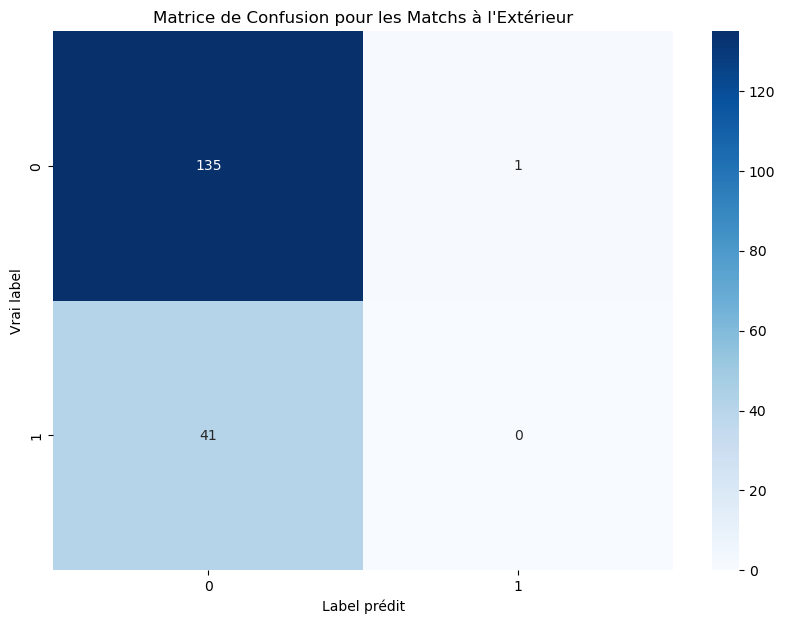

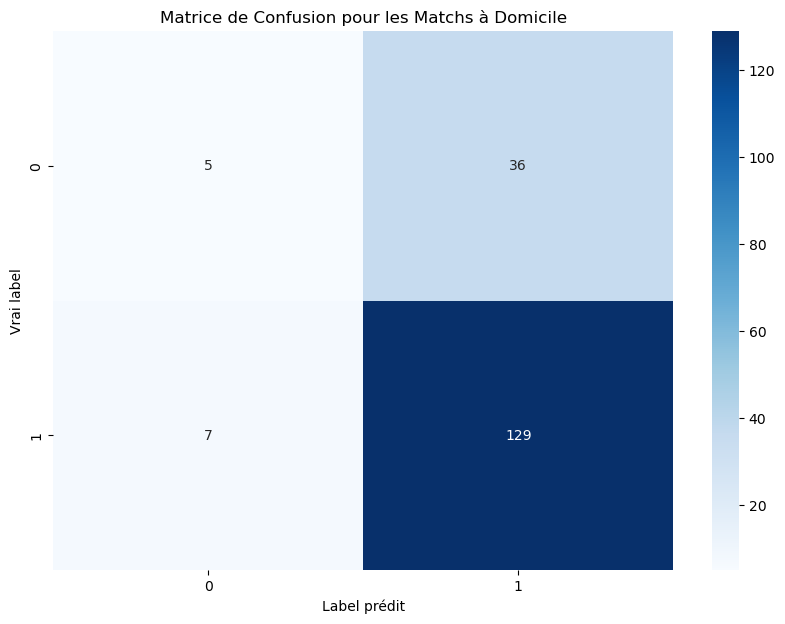

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('Vrai label')
    plt.xlabel('Label prédit')
    plt.show()

# Pour les matchs à l'extérieur
exterieur_mask = predicted_data_set['isHome'] == -1
plot_confusion_matrix(
    predicted_data_set[exterieur_mask]['isWinner'],
    predicted_data_set[exterieur_mask]['predictedIsWinner'],
    "Matrice de Confusion pour les Matchs à l'Extérieur"
)

# Pour les matchs à domicile
domicile_mask = predicted_data_set['isHome'] == 1
plot_confusion_matrix(
    predicted_data_set[domicile_mask]['isWinner'],
    predicted_data_set[domicile_mask]['predictedIsWinner'],
    "Matrice de Confusion pour les Matchs à Domicile"
)

In [19]:
print(regular_seasons_relative_without_draw_df[["isHome", "teamName", "matchName", "scoreDiff"]].head())

   isHome         teamName                     matchName  scoreDiff
0    -1.0           Toulon             Bayonne vs Toulon         -5
1     1.0          Bayonne             Bayonne vs Toulon          5
2     1.0  Bordeaux Begles  Bordeaux Begles vs Racing 92          6
3    -1.0        Racing 92  Bordeaux Begles vs Racing 92         -6
4    -1.0              Pau      Castres Olympique vs Pau        -17


['matchEspnId', 'matchName', 'season', 'matchDate', 'teamName', 'opponentTeamName', 'teamScore', 'opponentTeamScore', 'passes', 'offload', 'cleanBreaks', 'defendersBeaten', 'runs', 'carriesMetres', 'kickFromHandMetres', 'totalFreeKicksConceded', 'rucksLost', 'rucksWon', 'maulsWon', 'maulsLost', 'maulingMetres', 'turnoverWon', 'turnoversConceded', 'collectionFailed', 'collectionSuccess', 'tackleSuccess', 'missedTackles', 'scrumsWon', 'scrumsLost', 'lineoutsWon', 'lineoutsLost', 'redCards', 'yellowCards', 'penaltiesConceded', 'isHome']
1      2.0
2     -7.0
5      0.0
10     1.0
12   -10.0
Name: turnoversConceded, dtype: float64
1     1.0
2     1.0
5     1.0
10    1.0
12    1.0
Name: isHome, dtype: float64
1    -3.0
2     1.0
5     5.0
10    5.0
12   -3.0
Name: cleanBreaks, dtype: float64


c:\Users\hans9\.conda\envs\data_analysis-env\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\hans9\.conda\envs\data_analysis-env\Lib\site-packages\pingouin\effsize.py:809: RuntimeWarning: divide by zero encountered in scalar divide
  d = (x.mean() - y.mean()) / np.sqrt((x.var(ddof=1) + y.var(ddof=1)) / 2)


1     0.0
2     0.0
5     0.0
10    0.0
12    0.0
Name: maulingMetres, dtype: float64
1     0.0
2     0.0
5     0.0
10    0.0
12    0.0
Name: kickFromHandMetres, dtype: float64
1      38.0
2     140.0
5      38.0
10    163.0
12    -72.0
Name: carriesMetres, dtype: float64
1    -21.0
2     35.0
5     27.0
10    52.0
12    17.0
Name: passes, dtype: float64
1      5
2      6
5     17
10    34
12     8
Name: scoreDiff, dtype: int64
1    -5.0
2     0.0
5    -5.0
10   -7.0
12    1.0
Name: penaltiesConceded, dtype: float64
                  kpi    df  T-statistic       P-value     ci_low     ci_high  \
0   turnoversConceded  1053    -1.734002  8.321040e-02  -1.144680    0.070676   
1              isHome  1053          inf  0.000000e+00   2.000000    2.000000   
2         cleanBreaks  1053     9.200696  1.858812e-19   2.207924    3.404980   
3       maulingMetres  1053     4.660617  3.556496e-06   2.534542    6.220676   
4  kickFromHandMetres  1053     6.665469  4.247889e-11  51.215272   93.94

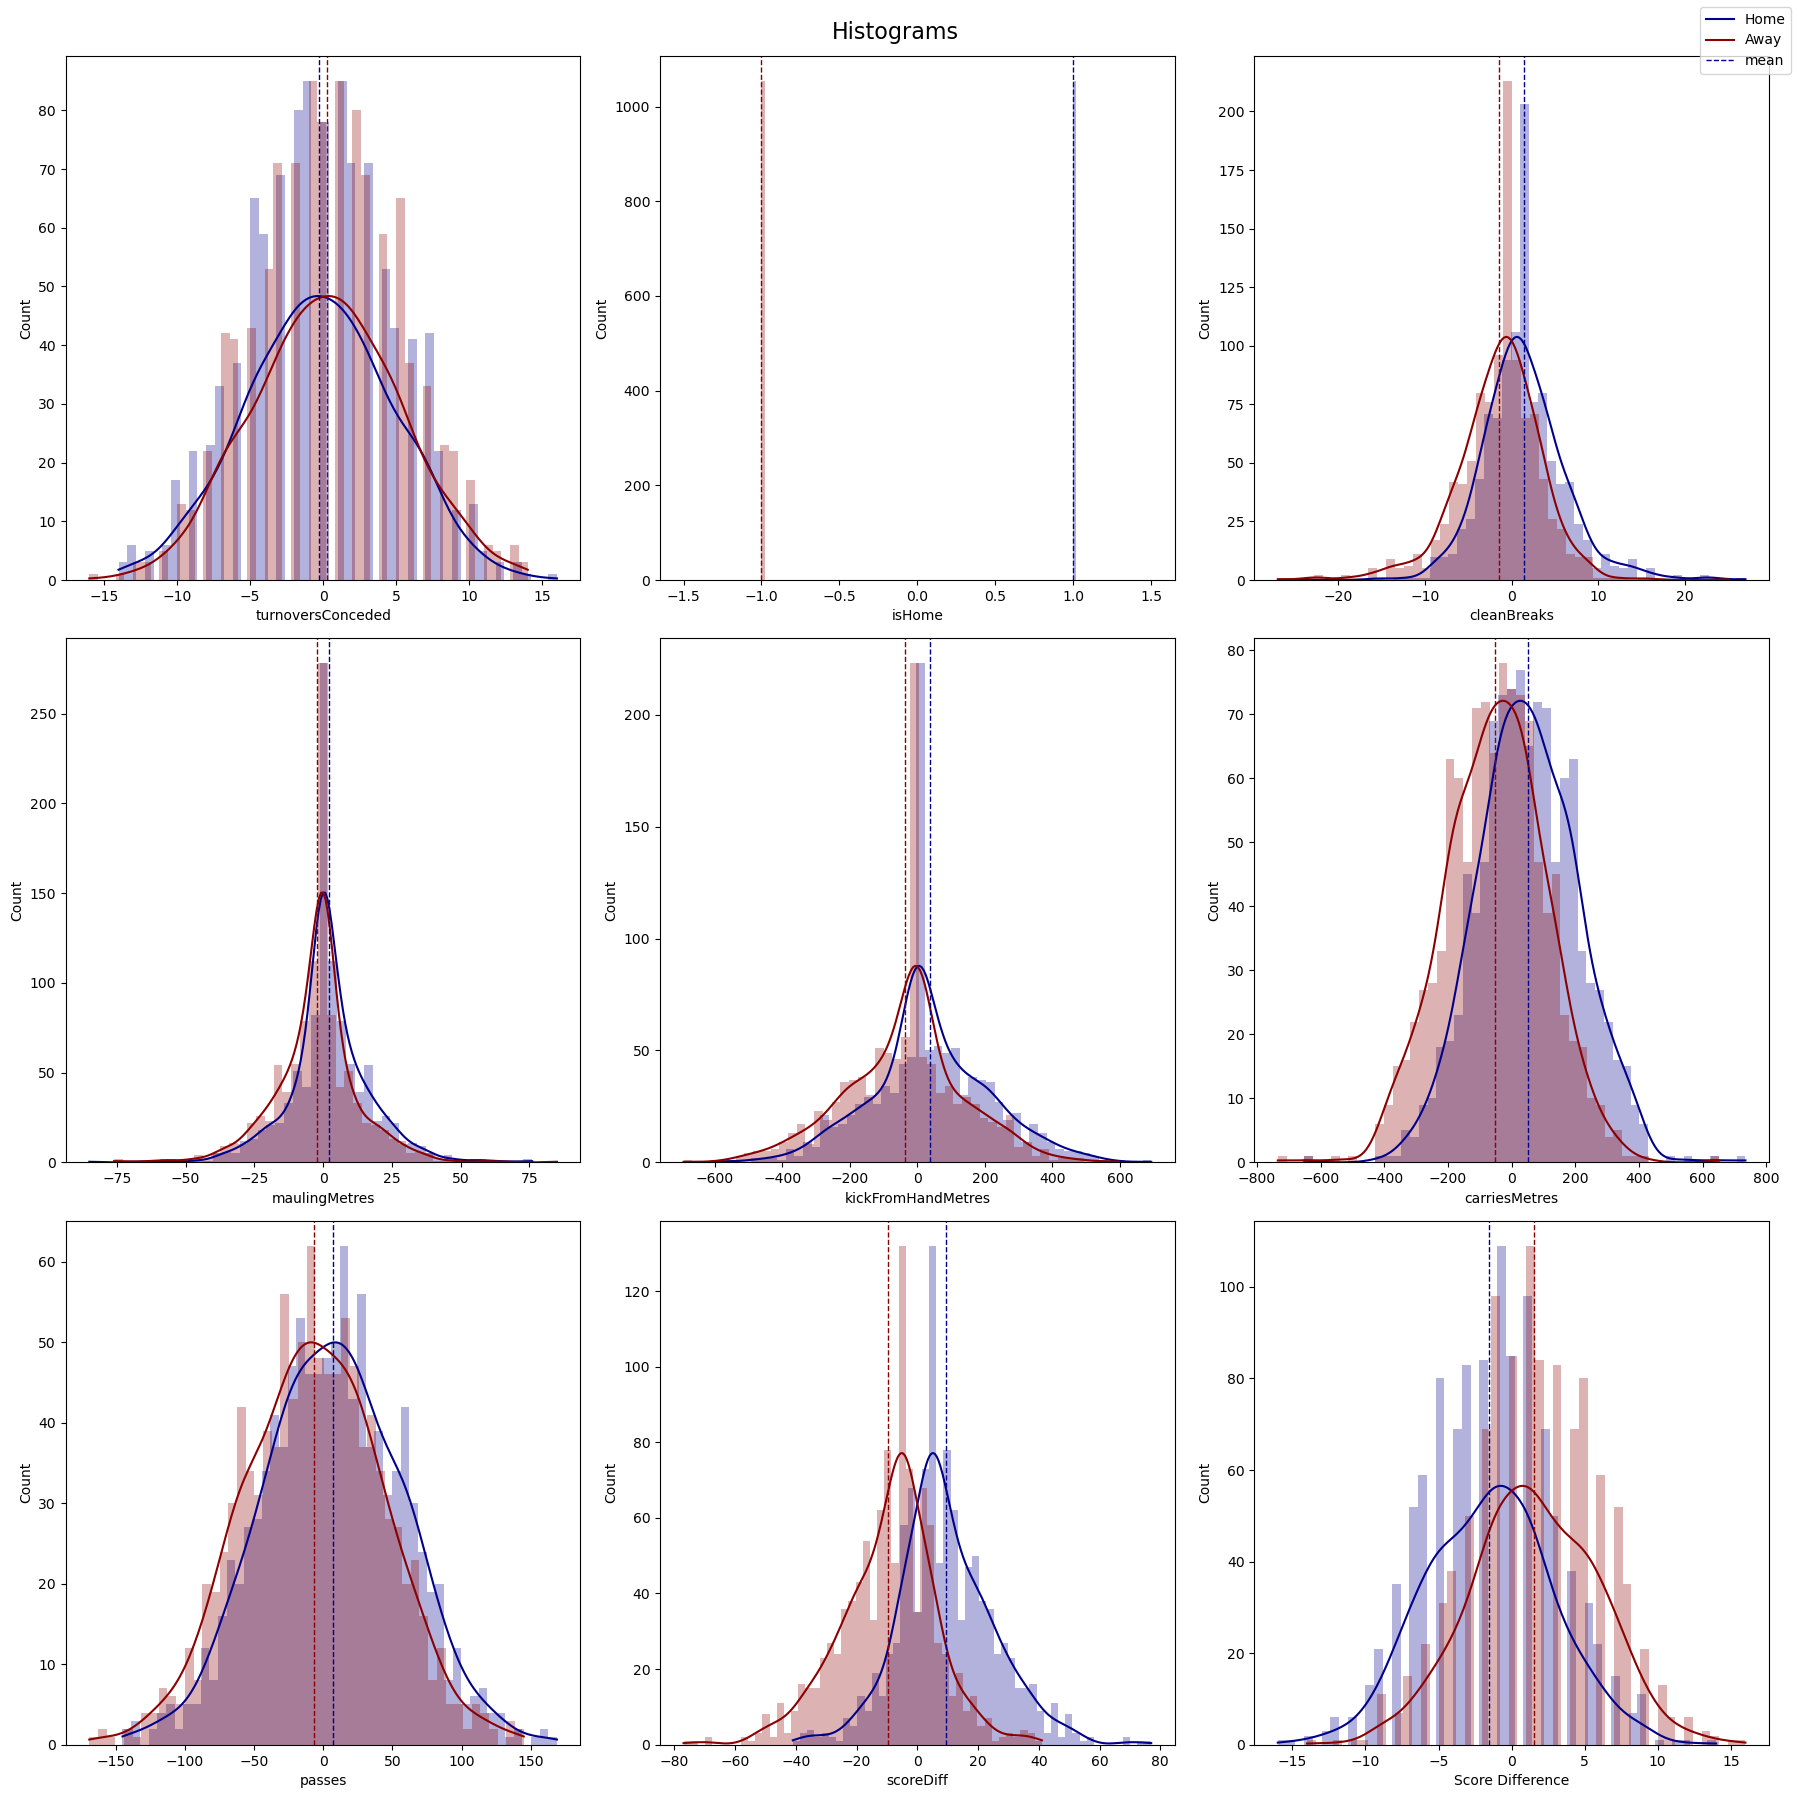

In [34]:
import math
import pingouin as pg

root = math.ceil(math.sqrt(len(intersection_selected_features + ["scoreDiff"])))
print(selected_features)

kpis = intersection_selected_features + ["scoreDiff"] + ["penaltiesConceded"]
n_kpis = len(kpis)
root = math.ceil(math.sqrt(n_kpis))
fig, axes = plt.subplots(root, root, figsize=(6 * root, 6 * root))
axes = axes.flatten()

home_values = regular_seasons_relative_without_draw_df[regular_seasons_relative_without_draw_df["isHome"] == 1]
away_values = regular_seasons_relative_without_draw_df[regular_seasons_relative_without_draw_df["isHome"] == -1]

# add mean to hist
# T-test + effect size
def stars(p_value):
    if 0.01 <= p_value < 0.05 :
        return "*"
    if 0.001 <= p_value < 0.01 :
        return "**"
    if p_value < 0.001 :
        return "***"
    return ""
    
stat_results = []
for n, kpi in enumerate(kpis):
    TtestResult = stats.ttest_rel(home_values[kpi], away_values[kpi])
    cohen_d = pg.compute_effsize(home_values[kpi], away_values[kpi], paired=True)
    home_summary = home_values[kpi].describe()
    away_summary = away_values[kpi].describe()
    summary = pd.concat([home_summary, away_summary], axis=1)
    stat_results.append({
        'kpi': kpi,
        'df': TtestResult.df,
        'T-statistic': TtestResult.statistic,
        'P-value': TtestResult.pvalue,
        'ci_low': TtestResult.confidence_interval().low,
        'ci_high': TtestResult.confidence_interval().high,
        'p-stars': stars(TtestResult.pvalue),
        'cohen_d': cohen_d
    })
    sns.histplot(home_values, x=kpi, color='darkblue', bins=50, alpha=0.3, edgecolor=None, stat='count', kde=True, ax=axes[n])
    sns.histplot(away_values, x=kpi,color='darkred', bins=50, alpha=0.3, edgecolor=None, stat='count', kde=True, ax=axes[n])
    axes[n].axvline(home_values[kpi].mean(), color='darkblue', linestyle='dashed', linewidth=1)
    axes[n].axvline(away_values[kpi].mean(), color='darkred', linestyle='dashed', linewidth=1)
for n in range(n_kpis, (root*root)) :
    fig.delaxes(axes[n])
results_df = pd.DataFrame(stat_results)
# Ajouter le titre et les labels
fig.suptitle('Histograms', fontsize= 16, y= 0.99)
fig.legend(['Home', 'Away', "mean"])
plt.xlabel('Score Difference')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Discussion

The primary aim of this study was to identify key performance indicators (KPIs) that best predict match outcomes in professional rugby union, specifically within the context of the Top 14 league. By employing a multi-method approach combining Recursive Feature Elimination with Cross-Validation (RFECV), Random Forest Feature Importance, and Permutation Feature Importance, we sought to provide a robust and comprehensive analysis of the relative importance of various game statistics in determining match results.

Our findings corroborate and extend previous research in rugby performance analysis by identifying a consistent set of Key Performance Indicators (KPIs) that emerge as significant predictors of match outcomes across diverse competitions and levels of play. Specifically, our study confirms the importance of carries, kick meters, clean breaks, and turnovers conceded as crucial factors in determining match results. This consistency is remarkable, as it aligns with findings from various elite rugby competitions, including men's Premiership rugby ([Bennett et al., 2018](../bibliography/Bennett%20&%20al.%20(2018).pdf)), the United Rugby Championship ([Scott et al., 2023, A](../bibliography/Scott%20&%20al.%20(2023,%20A).pdf)), international men's rugby ([Bennett et al., 2020](../bibliography/Bennett%20&%20al.%20(2020).pdf)), and international women's rugby union ([Scott et al., 2023, B](../bibliography/Scott%20&%20al.%20(2023,%20B).pdf)). The recurrence of these KPIs across different contexts underscores their universal relevance in rugby performance, transcending gender and competitive levels, and suggests a fundamental consistency in the key determinants of success in rugby union.


The identification of multiple KPIs spanning various aspects of play, including both offensive and defensive metrics, underscores the complex, multidimensional nature of rugby performance. This diversity in key indicators reinforces that success in rugby union is not determined by a single dominant factor, but rather by proficiency across multiple facets of the game. Otherwise, the emergence of 'isHome' as the most important feature across all methods underscores the significance of home advantage in rugby union of the Top 14 league.

In the following sections, we will discuss these findings in detail, exploring their implications for coaching practices, tactical decision-making, and future directions in rugby performance analysis. We will also address the limitations of our study and suggest avenues for further research to build upon this work.

## Home Advantage